In [ ]:
! pip install ultralytics
! pip install -U ray[tune]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 MB 12.0 MB/s eta 0:00:00


In [ ]:
import os
import random
import pandas as pd

import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
from ultralytics import YOLO
%matplotlib inline

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"moohamedelgebaly","key":"0c3ad4d0aefce2fff90c14af1547f78a"}'}

In [ ]:
import os
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json


In [ ]:
import kagglehub

path = kagglehub.dataset_download("slavkoprytula/aquarium-data-cots")

print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/aquarium-data-cots


In [ ]:
train_images = '/kaggle/input/aquarium-data-cots/aquarium_pretrain/train/images'
train_labels = '/kaggle/input/aquarium-data-cots/aquarium_pretrain/train/labels'

val_images = '/kaggle/input/aquarium-data-cots/aquarium_pretrain/valid/images'
val_labels = '/kaggle/input/aquarium-data-cots/aquarium_pretrain/valid/labels'

test_images = '/kaggle/input/aquarium-data-cots/aquarium_pretrain/test/images'
test_labels = '/kaggle/input/aquarium-data-cots/aquarium_pretrain/test/labels'

yaml_path = '/kaggle/input/aquarium-data-cots/aquarium_pretrain/data.yaml'

In [ ]:
classes = ['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']
Idx2Label = {idx: label for idx, label in enumerate(classes)}
Label2Index = {label: idx for idx, label in Idx2Label.items()}
print('Index to Label Mapping:', Idx2Label)
print('Label to Index Mapping:', Label2Index)

Index to Label Mapping: {0: 'fish', 1: 'jellyfish', 2: 'penguin', 3: 'puffin', 4: 'shark', 5: 'starfish', 6: 'stingray'}
Label to Index Mapping: {'fish': 0, 'jellyfish': 1, 'penguin': 2, 'puffin': 3, 'shark': 4, 'starfish': 5, 'stingray': 6}


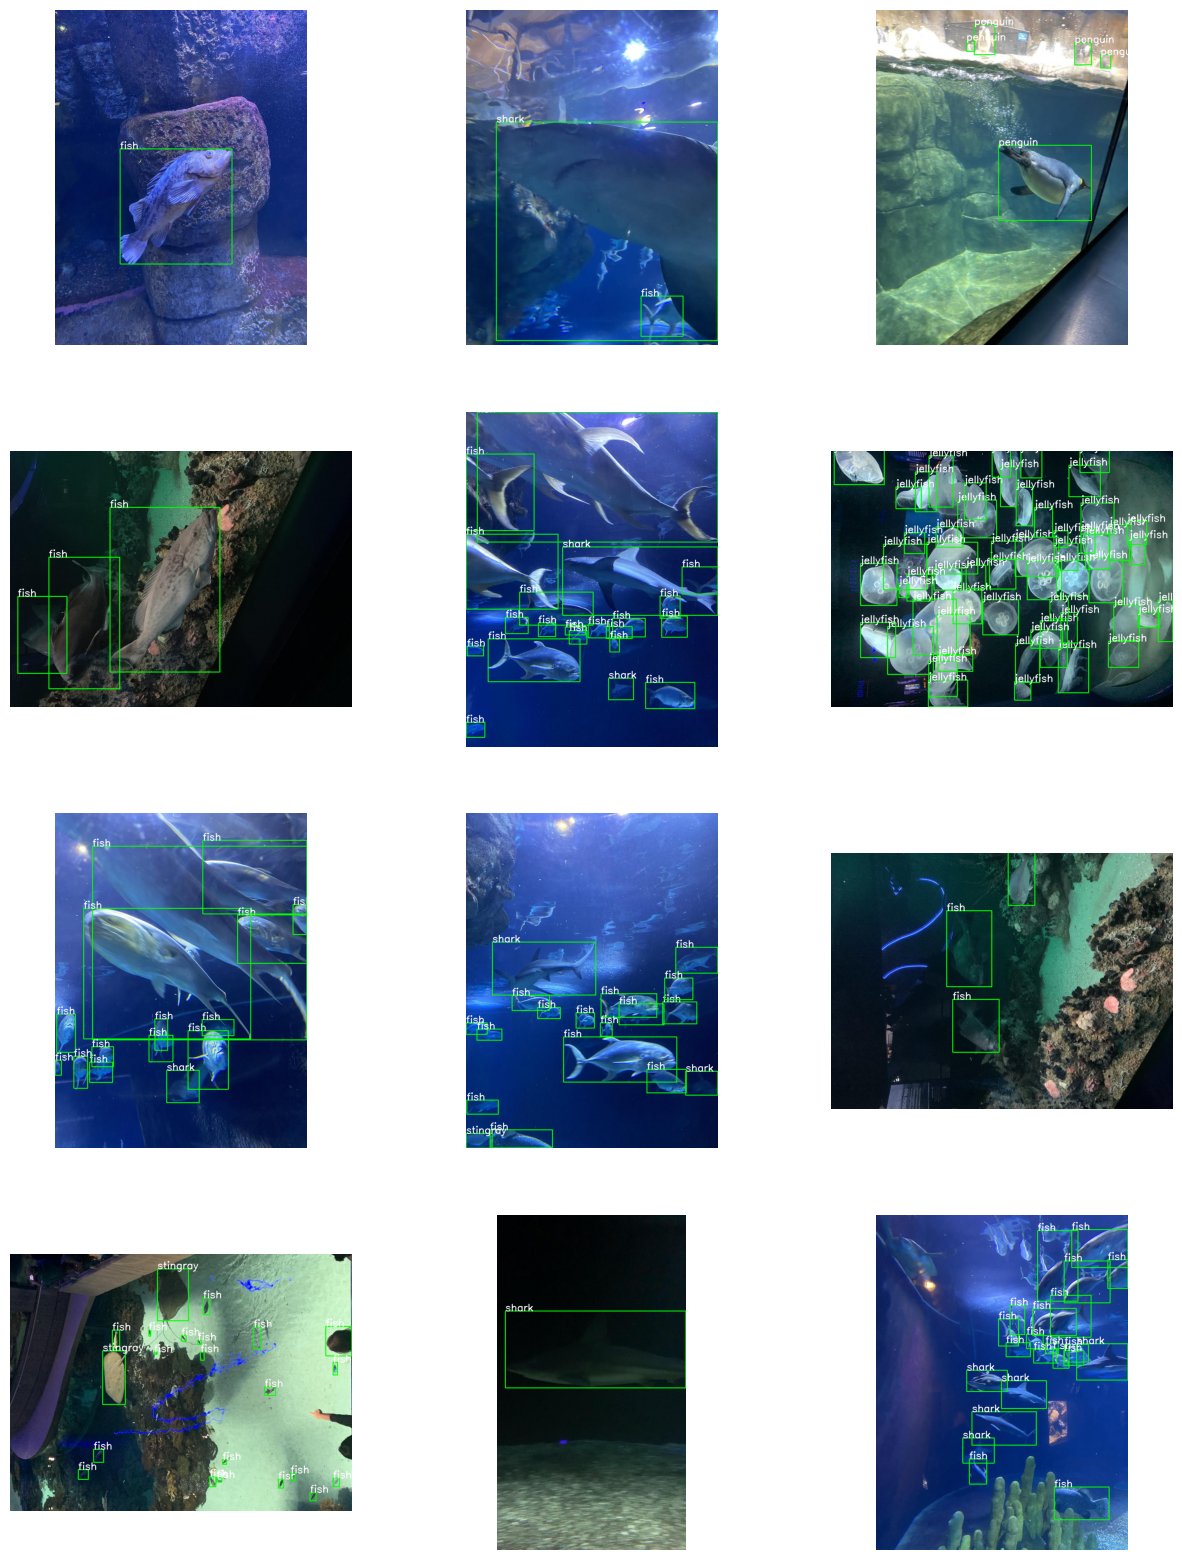

In [ ]:
def visualize_image_with_annotation_bboxes(image_dir, label_dir):
    image_files = sorted(os.listdir(image_dir))

    sample_image_files = random.sample(image_files, 12)

    fig, axs = plt.subplots(4, 3, figsize=(15, 20))

    for i, image_file in enumerate(sample_image_files):
        row = i // 3
        col = i % 3

        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label_path = os.path.join(label_dir, image_file[:-4] + '.txt')
        f = open(label_path, 'r')

        for label in f:
            class_id, x_center, y_center, width, height = map(float, label.split())
            h, w, _ = image.shape
            x_min = int((x_center - width/2) * w)
            y_min = int((y_center - height/2) * h)
            x_max = int((x_center + width/2) * w)
            y_max = int((y_center + height/2) * h)
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(image, Idx2Label[int(class_id)], (x_min, y_min), cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)

        axs[row, col].imshow(image)
        axs[row, col].axis('off')

    plt.show()

visualize_image_with_annotation_bboxes(train_images, train_labels)

In [ ]:
image_path = os.path.join(train_images, os.listdir(train_images)[100])
image = cv2.imread(image_path)

height, width, channels = image.shape
print('The image has dimensions {}x{} and {} channels'.format(height, width, channels))

The image has dimensions 1024x768 and 3 channels


In [ ]:
! pip install -U ipywidgets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 83.8 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [ ]:
import torch
from ultralytics import YOLO

device = torch.device('cuda:0')
model = YOLO('yolov8n.pt').to(device)

torch.cuda.empty_cache()

data_path = "/kaggle/input/aquarium-data-cots/aquarium_pretrain/data.yaml"

results = model.train(
    data=data_path,
    epochs=100,
    imgsz=640,
    batch=80,
    workers=8,
    save_period=10,
    lr0=5e-4,
    optimizer='AdamW',
    augment=True,
    name='yolov8n_custom',
    weight_decay=0.01,
)


engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=80, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/input/aquarium-data-cots/aquarium_pretrain/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_custom, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, project=None, rec

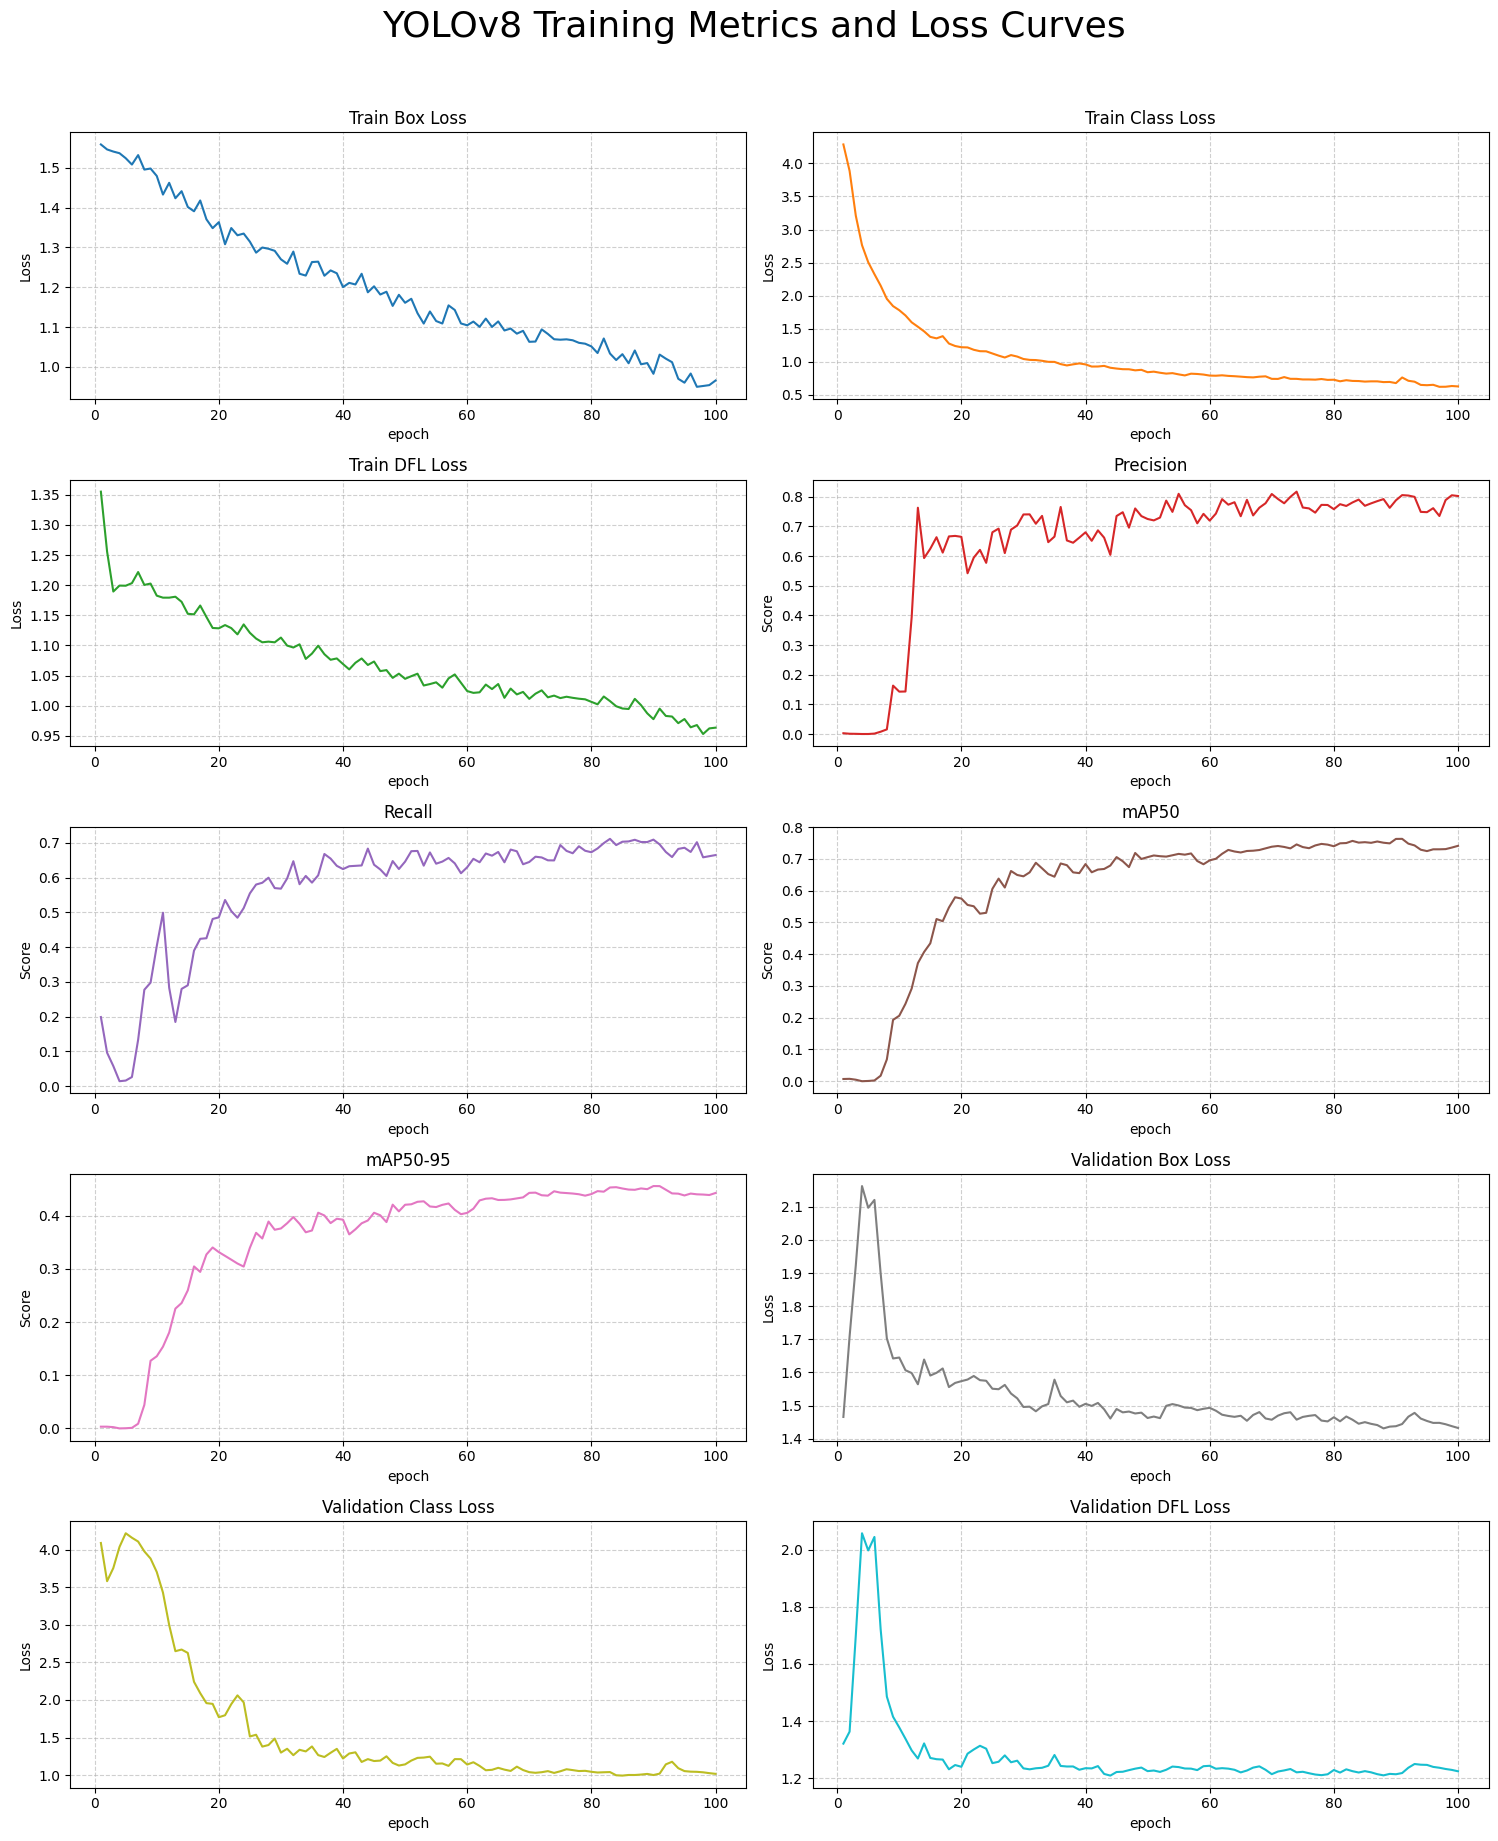

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('/content/runs/detect/yolov8n_custom/results.csv')
df.columns = df.columns.str.strip()  

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 18))

palette = sns.color_palette("tab10")

sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0], color=palette[0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1], color=palette[1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0], color=palette[2])

sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1], color=palette[3])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0], color=palette[4])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1], color=palette[5])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0], color=palette[6])

sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1], color=palette[7])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0], color=palette[8])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1], color=palette[9])

axs[0,0].set(title='Train Box Loss', ylabel='Loss')
axs[0,1].set(title='Train Class Loss', ylabel='Loss')
axs[1,0].set(title='Train DFL Loss', ylabel='Loss')
axs[1,1].set(title='Precision', ylabel='Score')
axs[2,0].set(title='Recall', ylabel='Score')
axs[2,1].set(title='mAP50', ylabel='Score')
axs[3,0].set(title='mAP50-95', ylabel='Score')
axs[3,1].set(title='Validation Box Loss', ylabel='Loss')
axs[4,0].set(title='Validation Class Loss', ylabel='Loss')
axs[4,1].set(title='Validation DFL Loss', ylabel='Loss')

for ax_row in axs:
    for ax in ax_row:
        ax.grid(True, linestyle="--", alpha=0.6)
        ax.legend([],[], frameon=False)  

plt.suptitle('YOLOv8 Training Metrics and Loss Curves', fontsize=26, y=1.02)

plt.tight_layout()
plt.show()


In [ ]:
from ultralytics import YOLO

model = YOLO('/content/runs/detect/yolov8n_custom/weights/best.pt')
results = model.val(data=dst_yaml, conf=0.25, split='test')


Ultralytics 8.3.189 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,013 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.6±0.3 ms, read: 11.2±3.4 MB/s, size: 70.7 KB)
val: Scanning /kaggle/input/aquarium-data-cots/aquarium_pretrain/test/labels... 63 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 63/63 73.1it/s 0.9s
WARNING ⚠️ val: Cache directory /kaggle/input/aquarium-data-cots/aquarium_pretrain/test is not writeable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 1.5it/s 2.7s
                   all         63        584      0.761      0.705      0.777      0.521
                  fish         30        249      0.698      0.687      0.727      0.456
             jellyfish         11        154      0.805      0.831      0.864      0.597
               penguin          7         82      0.772      0.661      0.771       0.3

In [ ]:
import cv2
import os
from ultralytics import YOLO

model = YOLO('/content/runs/detect/yolov8n_custom/weights/best.pt')

images_path = "/kaggle/input/aquarium-data-cots/aquarium_pretrain/test/images"

output_video_path = "/kaggle/working/test_video.mp4"

img_files = sorted([f for f in os.listdir(images_path) if f.endswith((".jpg", ".png"))])

first_frame = cv2.imread(os.path.join(images_path, img_files[0]))
height, width, _ = first_frame.shape

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, 5, (width, height))  # 5 FPS

for img_file in img_files:
    img_path = os.path.join(images_path, img_file)

    results = model.predict(img_path, save=False, conf=0.25)

    frame = results[0].plot()
    out.write(frame)

out.release()
print("Video saved at:", output_video_path)



image 1/1 /kaggle/input/aquarium-data-cots/aquarium_pretrain/test/images/IMG_2289_jpeg_jpg.rf.fe2a7a149e7b11f2313f5a7b30386e85.jpg: 640x480 1 puffin, 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /kaggle/input/aquarium-data-cots/aquarium_pretrain/test/images/IMG_2301_jpeg_jpg.rf.2c19ae5efbd1f8611b5578125f001695.jpg: 640x480 19 penguins, 5.9ms
Speed: 2.1ms preprocess, 5.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /kaggle/input/aquarium-data-cots/aquarium_pretrain/test/images/IMG_2319_jpeg_jpg.rf.6e20bf97d17b74a8948aa48776c40454.jpg: 640x480 7 penguins, 5.9ms
Speed: 2.1ms preprocess, 5.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /kaggle/input/aquarium-data-cots/aquarium_pretrain/test/images/IMG_2347_jpeg_jpg.rf.7c71ac4b9301eb358cd4a832844dedcb.jpg: 640x480 1 penguin, 5.9ms
Speed: 2.2ms preprocess, 5.9ms inference, 1.4ms postprocess per image at shape